For the notebook to be opertaional you can use this environment 
     
      source /afs/cern.ch/user/k/kostams/public/VirtualEnv/env.sh

In [1]:
%pylab inline
import numpy  as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as s
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,10)
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['savefig.facecolor'] = (1,1,1,1)

In [3]:
def plot_matrix(frame, **args):
    from matplotlib.colors import LogNorm
    x,y = np.meshgrid(np.array(frame.index,   dtype=float),
                      np.array(frame.columns, dtype=float))
    z = frame.T.values.astype(float)
    ret = gca().pcolor(y,x,z, **args)
    (lambda x: xlim(x[0],x[-1]))(frame.columns)
    (lambda x: ylim(x[0],x[-1]))(frame.index  ) 
    return ret

# Load the csvs and prepare the sets

In [4]:
load = True
if load:
    import gzip 
    args = { "header":None, "index_col": [0,1,2]}

    seriesB1034 = pd.Series.from_csv(gzip.open("seriesB1034.csv.gz","r"), **args)
    seriesB1034.index.names = ['Beta','R','TrueB']

    seriesB800  = pd.Series.from_csv(gzip.open("seriesB800.csv.gz","r"), **args)
    seriesB800.index.names = ['Beta','R','TrueB']

    seriesDeut  = pd.Series.from_csv(gzip.open("seriesDeuterons.csv.gz","r"), **args)
    seriesDeut.index.names = ['Beta','R','TrueB']

    args['index_col'] = [0,1]
    seriesData  = pd.Series.from_csv(gzip.open("seriesData.csv.gz","r"), **args)
    seriesData.index.names = ['Beta','R']

In [5]:
resP = seriesB800.sort_index().loc[0:,0:,0:]
resP = resP.unstack().fillna(0).stack()
resD = seriesDeut.sort_index().loc[0:,0:,0:]
resD = resD.unstack().fillna(0).stack()
obs  = seriesData.sort_index().loc[0:,0:]

# Masking

In [6]:
def expectedCounts(resolutions,fluxes,mask=None):
    """ Makes expectd counts given a list of fluxes and a list of resolution matrices"""
    expected = None
    for res,flux in zip(resolutions,fluxes):
        if expected is None:
            expected  = res.unstack(level=2).dot(flux)
        else:
            expected += res.unstack(level=2).dot(flux)
    if mask is not None: expected[mask]=0
    return expected

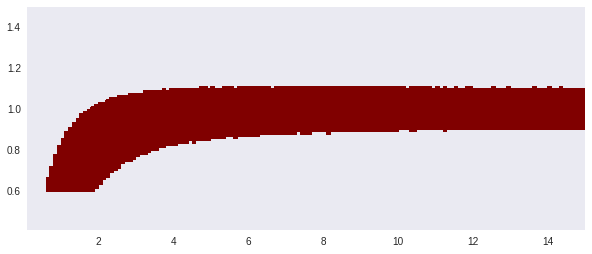

In [76]:
figsize(10,4)
mp,md = 0.938, 1.875
def R_from_beta(beta, m=mp):
    return m*beta/np.sqrt(1-beta*beta)
def Ek_from_beta(beta):
    return mp/np.sqrt(1-beta*beta) - mp
def beta_from_R(R, m=mp):
    return R/np.sqrt(R**2+m**2)

oneFlx = pd.Series(1.0,resP.index.levels[2])
expected = expectedCounts([resP, resD], [oneFlx,oneFlx])

tframe = expected.reset_index()
tframe['mask']  = tframe['Beta'] - beta_from_R(tframe['R'], mp) > 0.12
tframe['mask'] |= tframe['Beta'] < 0.6
tframe['mask'] |= tframe['R']    < 0.5
tframe.set_index(['Beta','R'], inplace=True)
mask = tframe['mask'] | (expected < 100)

expected[mask] = 0
plot_matrix(expected.unstack().iloc[1:,1:],norm=LogNorm(vmin=10**(-5),vmax=10))

# TemplateFit

In [50]:
templates = np.concatenate([ 
    resP.unstack()[~mask].T.values, 
    resD.unstack()[~mask].T.values
])
data = obs[~mask].values

In [51]:
def get_exps(p, t):
    """ This numerially solves the equations for templates"""
    np.seterr(divide='ignore', invalid='ignore')
    
    p = p[:,np.newaxis]
    for _ in range(10):
        f =  data / (1 - t)    - ( p * templates  / (1 + t[np.newaxis,:] * p)    ).sum(axis=0)
        fd = data / (1 - t)**2 + ((p**2)*templates/ (1 + t[np.newaxis,:] * p)**2 ).sum(axis=0)
        t = t - f/fd
        
    t[np.isnan(t)] = 1
    ex = templates / (1 + t[np.newaxis,:] * p)
    np.seterr(divide='warn', invalid='warn')
    return ex

In [52]:
t = np.zeros_like(data)
fl = np.ones(templates.shape[0])

In [53]:
for i in range(100):
    if i % 10 == 0: print fl
    ex = get_exps(fl,t)
    np.seterr(divide='ignore', invalid='ignore')
    fl += 0.001 * (nan_to_num((data/(ex*fl[:,np.newaxis]).sum(axis=0) - 1))*ex).sum(axis=1)
    fl[fl<0] = 0

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[   1.            1.            1.            1.            1.            1.
    1.            1.            1.            1.            1.

(0.5, 6)

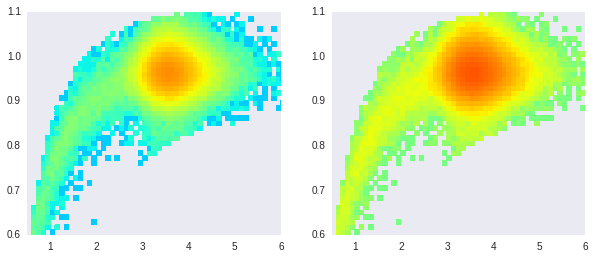

In [61]:
nn = 50
subplot(121)
plot_matrix( 
    pd.Series(ex[nn],index=mask[~mask].index).unstack().fillna(0),
    norm=LogNorm(vmin=10**(-5),vmax=sum(ex[nn])))
xlim(0.5,6)
subplot(122)
plot_matrix( 
    pd.Series(templates[nn],index=mask[~mask].index).unstack().fillna(0),
    norm=LogNorm(vmin=10**(-5),vmax=sum(templates[nn])))
xlim(0.5,6)

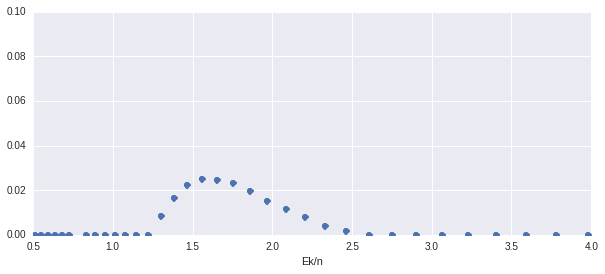

In [96]:
flt = fl / ex.sum(axis=1)
p_result = pd.Series(flt[:106],
    index=Ek_from_beta(resP.index.levels[-1]))

d_over_p = pd.Series(flt[106:]/flt[:106],
    index=Ek_from_beta(resP.index.levels[-1]))
d_over_p.index.name = 'Ek/n'
d_over_p.plot(marker='o', lw=0)
xlim(0.5,4);
ylim(0.0,0.1);

In [87]:
# This does the parsing
def request_and_parse(url):
    import warnings; warnings.filterwarnings('ignore')
    import requests
    data = requests.get(url)
    cols, frame = [], []
    for l in data.text.splitlines():
        if l[0] == '#': 
            if not 'Col' in l: continue
            cols.append(' '.join(l.split()[3:]))
            continue
        frame.append(l.split())
    frame = pd.DataFrame(frame, columns=cols)
    frame.iloc[:,3:11] = frame.iloc[:,3:11].astype(float)
    return frame

def doplt(frame):
    nerr = frame.iloc[:,[7, 9]].sum(axis=1)
    perr = frame.iloc[:,[8,10]].sum(axis=1)
    errorbar(frame.iloc[:,3],frame.iloc[:,6], yerr=[-nerr, perr], fmt='D', label=frame.name)
    return frame

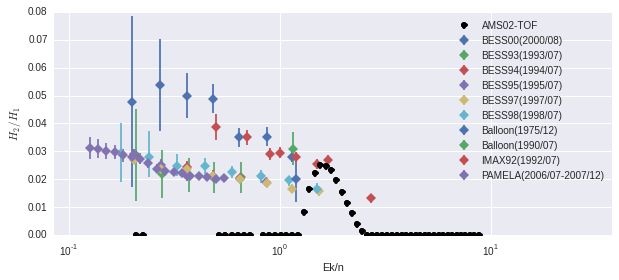

In [91]:
frame = request_and_parse("https://lpsc.in2p3.fr/cosmic-rays-db/_dialog_result.php?num=2H&den=1H&energy_type=EKN")
frame.groupby(frame.columns[1]).apply(doplt);

xscale('log')
xlabel("Ekn, [GeV/n]")
ylabel("$H_2/H_1$")
d_over_p.plot(marker='o', lw=0, color='k', label='AMS02-TOF')

legend()

In [92]:
frame = request_and_parse("https://lpsc.in2p3.fr/cosmic-rays-db/_dialog_result.php?num=H&energy_type=EKN")

(0, 400)

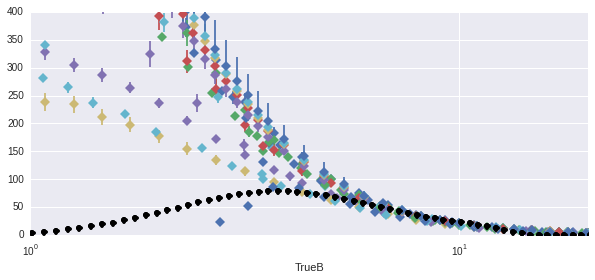

In [105]:
frame.groupby(frame.columns[1]).apply(doplt);
(100*p_result).plot(marker='o', lw=0, color='k', label='AMS02-TOF')
xscale('log')
xlim(1,20)
ylim(0,400)

In [106]:
%run ~/AMSDeutons/1.exposureTime/exposureTime.py

ImportError: No module named bigQueryPlotting